In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import re
import pickle

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [16]:
bow_X_tr_reduced = openfromfile(r'D:\Studies\AppliedAi\AmazonFoodReviews\bow_X_tr')
tfidf_X_tr_reduced = openfromfile(r'D:\Studies\AppliedAi\AmazonFoodReviews\tfidf_X_tr')

In [3]:
conn = sqlite3.connect(r'D:\Studies\AppliedAi\AmazonFoodReviews\Cleaned_Text.sqlite')

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews""", conn)

filtered_data.head()

,level_0,index,Time,Score,Text,CleanedText
0,0,212458,948240000,negative,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
1,1,1146,961718400,positive,This was a really good idea and the final prod...,realli good idea final product outstand use de...
2,2,1145,962236800,positive,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
3,3,212454,997228800,negative,I am continually amazed at the shoddy treatmen...,continu amaz shoddi treatment movi get dvd rel...
4,4,212457,1040947200,negative,"Just to let you know, this movie is one of my ...",let know movi one person favorit ghost movi sa...


In [5]:
filtered_data.shape

(60000, 6)

In [7]:
import random
# generate random 5000 numbers. These numbers will be used to fetch reviews
random_indices = random.sample(range(0,60000), 5000) 

In [8]:
filtered_data_reduced = filtered_data.iloc[random_indices]

In [9]:
filtered_data_reduced = filtered_data_reduced['CleanedText'].tolist()

In [11]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
def Get_List_of_Sentences(cleanedText):
    list_of_sent=[]
    for sent in cleanedText:
        list_of_sent.append(sent.split())
    return list_of_sent

In [5]:
def Get_Word2Vec_Vectors(list_of_sent):
    w2v_model = Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    return w2v_model

In [6]:
def GetAvgW2V_Vectors(list_of_sent, w2v_model):
    w2v_words = list(w2v_model.wv.vocab)
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    
    return sent_vectors

In [26]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)

#fit and transform train data
tfidf_X_tr = tfidf_vectorizer.fit_transform(filtered_data_reduced)

tfidf_X_tr = ColumnStandardization(tfidf_X_tr)

In [12]:
X_tr_listOfSent = Get_List_of_Sentences(filtered_data_reduced)
X_tr_w2vModel = Get_Word2Vec_Vectors(X_tr_listOfSent)

In [13]:
# Get Average word2vec vector for each set of data -> Column standardize those vectors
avg_X_tr = GetAvgW2V_Vectors(X_tr_listOfSent, X_tr_w2vModel)

In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vectorizer.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
w2v_words = list(X_tr_w2vModel.wv.vocab)
for sent in X_tr_listOfSent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2vModel.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            if word in tfidf_feat:
                tf_idf = tfidf_X_tr[row, tfidf_feat.index(word)]
            else:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
standardizer = StandardScaler(with_mean=False)
avg_X_tr = standardizer.fit_transform(avg_X_tr)

## K-Means

#### BOW

In [ ]:
elbow_dict = {}
for k in range(2,10):
    cluster_model = KMeans(k, n_jobs = -1).fit(bow_X_tr_reduced)
    elbow_dict[k] = cluster_model.inertia_

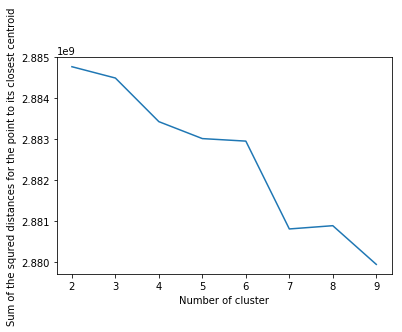

In [29]:
plt.figure()
plt.plot(list(elbow_dict.keys()), list(elbow_dict.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of the squred distances for the point to its closest centroid")
plt.show()

In [30]:
best_k = np.argmin(list(elbow_dict.values())) + 2
best_model = KMeans(best_k, n_jobs = -1).fit(bow_X_tr_reduced)

In [45]:
best_k

9

In [18]:
best_model = KMeans(9, n_jobs = -1).fit(bow_X_tr_reduced)

In [20]:
labels = np.array(best_model.labels_)
cluster_0 = np.where(labels == 0)[0]
cluster_1 = np.where(labels == 1)[0]
cluster_2 = np.where(labels == 2)[0]
cluster_3 = np.where(labels == 3)[0]
cluster_4 = np.where(labels == 4)[0]
cluster_5 = np.where(labels == 5)[0]
cluster_6 = np.where(labels == 6)[0]
cluster_7 = np.where(labels == 7)[0]
cluster_8 = np.where(labels == 8)[0]
cluster_9 = np.where(labels == 9)[0]

In [21]:
cluster_0

array([8520], dtype=int64)

In [22]:
cluster_1

array([ 6273, 14535], dtype=int64)

In [23]:
cluster_2

array([  974,  5433,  5539,  5545,  5550,  5568,  5842,  6418,  7850,
       11593, 17962, 19887, 23128, 23137, 23277, 23540, 23802, 24059,
       24192, 24994, 31798], dtype=int64)

In [24]:
cluster_0_reviews = filtered_data.iloc[list(cluster_0),:]['CleanedText'].tolist()
cluster_1_reviews = filtered_data.iloc[list(cluster_1),:]['CleanedText'].tolist()
cluster_2_reviews = filtered_data.iloc[list(cluster_2),:]['CleanedText'].tolist()
cluster_3_reviews = filtered_data.iloc[list(cluster_3),:]['CleanedText'].tolist()
cluster_4_reviews = filtered_data.iloc[list(cluster_4),:]['CleanedText'].tolist()
cluster_5_reviews = filtered_data.iloc[list(cluster_5),:]['CleanedText'].tolist()
cluster_6_reviews = filtered_data.iloc[list(cluster_6),:]['CleanedText'].tolist()
cluster_7_reviews = filtered_data.iloc[list(cluster_7),:]['CleanedText'].tolist()
cluster_8_reviews = filtered_data.iloc[list(cluster_8),:]['CleanedText'].tolist()

In [22]:
from wordcloud import WordCloud

In [26]:
cluster_0_reviews = " ".join(cluster_0_reviews)

In [28]:
wc = WordCloud().generate(cluster_0_reviews)

(-0.5, 399.5, 199.5, -0.5)

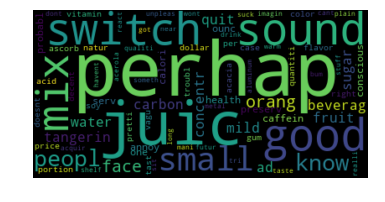

In [29]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

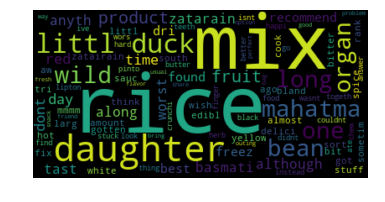

In [30]:
cluster_1_reviews = " ".join(cluster_1_reviews)
wc = WordCloud().generate(cluster_1_reviews)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

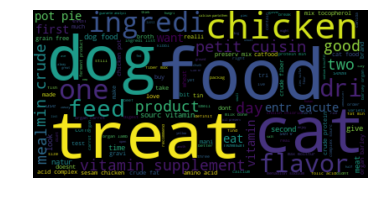

In [31]:
cluster_2_reviews = " ".join(cluster_2_reviews)
wc = WordCloud().generate(cluster_2_reviews)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

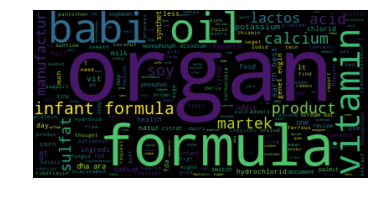

In [33]:
cluster_3_reviews = " ".join(cluster_3_reviews)
wc = WordCloud().generate(cluster_3_reviews)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

1. Cluster 0 is mostly filled with liquid products like Juice
2. Cluster 1 are raw materials for cooking like rice, spices
3. CLuster 2 is pet food
4. Cluster 3 is about infant products

#### Average w2v

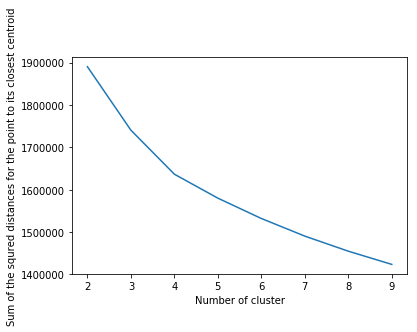

Best k - 9
*******************************************************************************************************************************
Cluster Number 0
This coffee K-cup was the worst ever. It leaks when you lift it out of the k-cup holder..(extra thin plastic)..and the grounds run into the cup with the coffee. I guess you get what you pay for.
-------------------------------------------------------------------------------------------------------------------------------
I have enjoyed creme brulee on many occasions and thought that this coffee would provide a hint of that delicious dessert.  It has a strange and unpleasant aftertaste.  If, after tasting this coffee, someone offered me a menu featuring Creme Brulee for dessert, I would avoid it at all costs.  There is no flavor in this coffee that bears any resemblance to Creme Brulee.
-------------------------------------------------------------------------------------------------------------------------------
I use this coffee for

In [89]:
elbow_dict = {}
for k in range(2,10):
    cluster_model = KMeans(k, n_jobs = -1).fit(avg_X_tr)
    elbow_dict[k] = cluster_model.inertia_

plt.figure()
plt.plot(list(elbow_dict.keys()), list(elbow_dict.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of the squred distances for the point to its closest centroid")
plt.show()

best_k = np.argmin(list(elbow_dict.values())) + 2
print(f'Best k - {best_k}')
best_model = KMeans(best_k, n_jobs = -1).fit(avg_X_tr)

labels = np.array(best_model.labels_)

for cluster_label in range(0, best_k):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue

    print("*" * 127)
    print("=" * 30)
    print(f'Cluster Number {cluster_label}')
    print("=" * 30)
    
    cluster_reviews = filtered_data.iloc[list(grouped_cluster),:]['Text'].tolist()
    
    random_indices = random.sample(range(0,grouped_cluster.size), 3) 
    
    for i in random_indices:
        print(cluster_reviews[i])
        print("-" * 127)
    
    print("*" * 127)

#### Tfidf

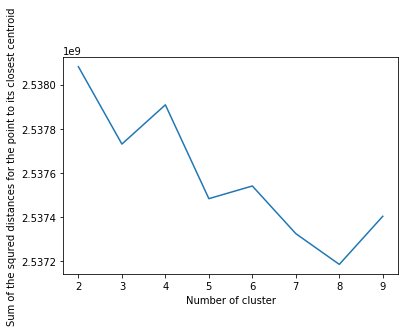

In [90]:
elbow_dict = {}
for k in range(2,10):
    cluster_model = KMeans(k, n_jobs = -1).fit(tfidf_X_tr_reduced)
    elbow_dict[k] = cluster_model.inertia_

plt.figure()
plt.plot(list(elbow_dict.keys()), list(elbow_dict.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of the squred distances for the point to its closest centroid")
plt.show()

In [34]:
best_model = KMeans(8, n_jobs = -1).fit(tfidf_X_tr_reduced)

------------0----------------
------------1----------------
------------2----------------
------------6----------------
------------7----------------


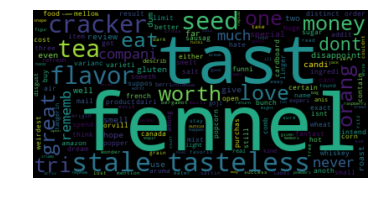

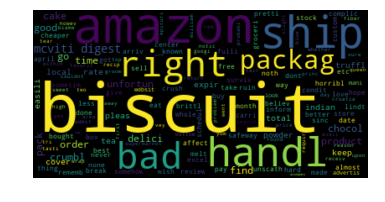

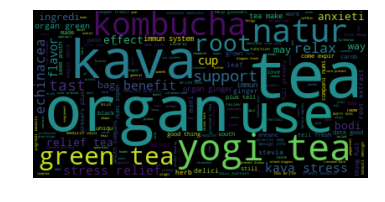

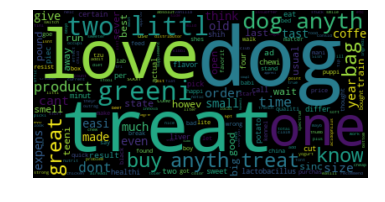

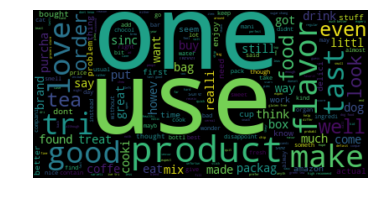

In [37]:
labels = np.array(best_model.labels_)

for cluster_label in range(0, 8):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue

    cluster_reviews = filtered_data.iloc[list(grouped_cluster),:]['CleanedText'].tolist()
    cluster_reviews = " ".join(cluster_reviews)
    wc = WordCloud().generate(cluster_reviews)
    plt.figure(cluster_label)
    print(f'------------{cluster_label}----------------')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

<ul>Although we are not able to identotfyy what cluster 0 reviews are about, They are mostly negative reviews</ul>
<ul>Cluster 1 has garnered mostly good reviews about biscuites and amazon shipping</ul>
<ul>Cluster 2 about tea</ul>
<ul>Cluster 6 about pet food</ul>
<ul>Cluster 7 is hard to figure out what most of the reviews are about</ul>

#### Tfidf word to vec

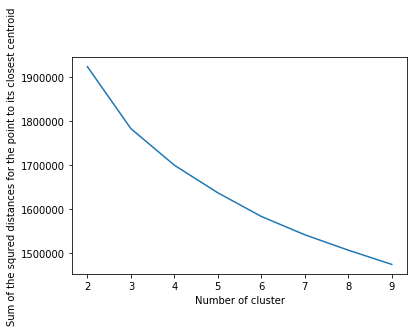

Best k - 9
*******************************************************************************************************************************
Cluster Number 0
In the mood for something extra, extra, extra sweet? You will enjoy this cookie then. Otherwise just buy when you have a big crowd. The first cookie isn't bad but all others after that just add up to an unpleasant eating experience.<br /><br />As far as taste is concerned, past the super sweetness, it does taste pretty good with plenty of chocolaty peanut butter flavor.<br /><br />But, wow, are they sweet! How did Nabisco pack so much sweet into such a small cookie?<br /><br />The cookie is about as thin as one side of the Oreo creme filled cookie. Kudos to Nabisco for actually covering the whole cookie with fudge and not just the front side. There is a thin layer of some sort of peanut butter creme on the top side of the cookie under the fudge coating. The PB seems to be where most of the awful sweetness is coming from.<br /><br />

In [92]:
elbow_dict = {}
for k in range(2,10):
    cluster_model = KMeans(k, n_jobs = -1).fit(avgtfidf_X_tr)
    elbow_dict[k] = cluster_model.inertia_

plt.figure()
plt.plot(list(elbow_dict.keys()), list(elbow_dict.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of the squred distances for the point to its closest centroid")
plt.show()

best_k = np.argmin(list(elbow_dict.values())) + 2
print(f'Best k - {best_k}')
best_model = KMeans(best_k, n_jobs = -1).fit(avgtfidf_X_tr)

labels = np.array(best_model.labels_)

for cluster_label in range(0, best_k):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue
    
    print("*" * 127)
    print("=" * 30)
    print(f'Cluster Number {cluster_label}')
    print("=" * 30)
    
    cluster_reviews = filtered_data.iloc[list(grouped_cluster),:]['Text'].tolist()
    
    random_indices = random.sample(range(0,grouped_cluster.size), 3) 
    
    for i in random_indices:
        print(cluster_reviews[i])
        print("-" * 127)
        
    print("*" * 127)

------------0----------------
------------1----------------
------------2----------------
------------3----------------
------------4----------------
------------5----------------
------------6----------------
------------7----------------


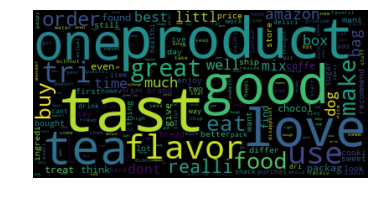

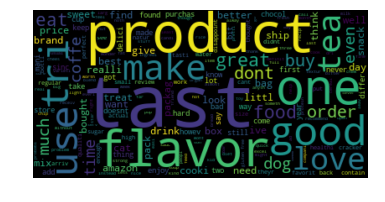

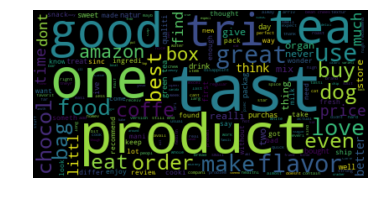

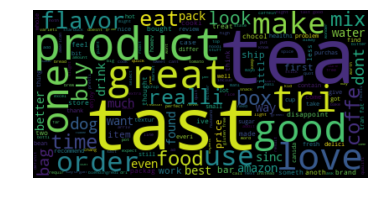

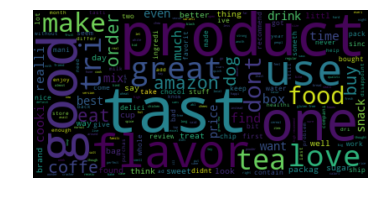

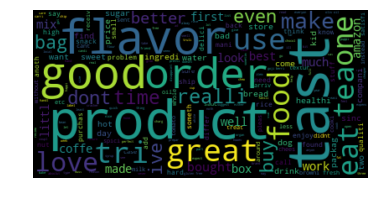

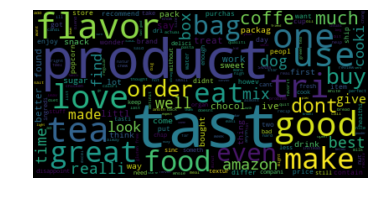

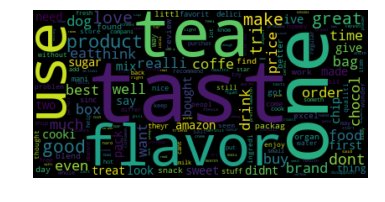

In [32]:
best_model = KMeans(9, n_jobs = -1).fit(tfidf_sent_vectors)
labels = np.array(best_model.labels_)

for cluster_label in range(0, 8):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue

    cluster_reviews = filtered_data.iloc[list(grouped_cluster),:]['CleanedText'].tolist()
    cluster_reviews = " ".join(cluster_reviews)
    wc = WordCloud().generate(cluster_reviews)
    plt.figure(cluster_label)
    print(f'------------{cluster_label}----------------')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

The avg Tfidf clusters are not usefull. They do not reveal any theme about the clusters

## Alglomerative Clustering

In [25]:
from sklearn.preprocessing import StandardScaler
def ColumnStandardization(train_data):
    """ Column standardization to get unit variance.
    with_mean is set to false so that it works for sparse matrix
    """
    standardizer = StandardScaler(with_mean=False)
    std_train_data = standardizer.fit_transform(train_data)
    return std_train_data

In [33]:
count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=5)

#fit and transform train data
bow_X_tr = count_vectorizer.fit_transform(filtered_data_reduced)

bow_X_tr = ColumnStandardization(bow_X_tr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### BOW

In [95]:
am_2_Clusters_ward_linkage = AgglomerativeClustering(linkage="ward", n_clusters=2).fit(bow_X_tr.toarray())

In [98]:
labels = np.array(am_2_Clusters_ward_linkage.labels_)

for cluster_label in range(0, 2):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue
    
    print("*" * 127)
    print("=" * 30)
    print(f'Cluster Number {cluster_label}')
    print("=" * 30)
    
    random_indices = random.sample(range(0,grouped_cluster.size), 3) 
    
    for i in random_indices:
        print(filtered_data_reduced[i])
        print("-" * 127)
        
    print("*" * 127)

*******************************************************************************************************************************
Cluster Number 0
childhood nostagia love peanut butter jelli sandwich dont often make theyr rather messi bar solv problem oat stuff provid perfect compliment peanut butter jelli flavor that bar best part eat worri hand cloth get mess
-------------------------------------------------------------------------------------------------------------------------------
dishonest compani ingredi line differ bottl product gluten natur flavor mention line surpris amazon insenset dishonesti throw away bottl sinc return dishonest dishonest dishonest
-------------------------------------------------------------------------------------------------------------------------------
flavor bought get high review amazon kohl purchas store kohl disappoint lack flavor coffe much chocol flavor tast brew
------------------------------------------------------------------------------------

In [99]:
am_4_Clusters_average_linkage = AgglomerativeClustering(linkage="average", n_clusters=4).fit(bow_X_tr.toarray())

In [101]:
labels = np.array(am_4_Clusters_average_linkage.labels_)

for cluster_label in range(0, 4):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue
    
    print("*" * 127)
    print("=" * 30)
    print(f'Cluster Number {cluster_label}')
    print("=" * 30)
    
    random_indices = random.sample(range(0,grouped_cluster.size), 3) 
    
    for i in random_indices:
        print(filtered_data_reduced[i])
        print("-" * 127)
        
    print("*" * 127)

*******************************************************************************************************************************
Cluster Number 0
vanilla powder thought could get away never get disappoint tast bit graini
-------------------------------------------------------------------------------------------------------------------------------
great product kid love good cook buy store cost quit abit singl pack pack good deal
-------------------------------------------------------------------------------------------------------------------------------
one three packag ladi finger type ined pop could determin use two type
-------------------------------------------------------------------------------------------------------------------------------
*******************************************************************************************************************************


In [103]:
grouped_cluster = np.where(labels == 2)[0]
grouped_cluster

array([1256], dtype=int64)

In [104]:
grouped_cluster = np.where(labels == 1)[0]
grouped_cluster

array([3547], dtype=int64)

In [105]:
grouped_cluster = np.where(labels == 3)[0]
grouped_cluster

array([941], dtype=int64)

#### TFIDF

In [106]:
am_4_Clusters_complete_linkage = AgglomerativeClustering(linkage="complete", n_clusters=4).fit(tfidf_X_tr.toarray())

In [109]:
labels = np.array(am_4_Clusters_complete_linkage.labels_)

for cluster_label in range(0, 4):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue
    
    print("*" * 127)
    print("=" * 30)
    print(f'Cluster Number {cluster_label}')
    print("=" * 30)
    
    random_indices = random.sample(range(0,grouped_cluster.size), 3) 
    
    for i in random_indices:
        print(filtered_data_reduced[i])
        print("-" * 127)
        
    print("*" * 127)

*******************************************************************************************************************************
Cluster Number 0
best tea tri good tast feel energi drink
-------------------------------------------------------------------------------------------------------------------------------
often wonder much time invest make dog food look like someth feel better give pet food look nice differ color meati look moist chunk dog love eat pound great right read food dog food advisor dot com would never get food deceiv beef first ingredi explain review dog food advisor weight beef dri process contain lot water process probabl much lower percentag ingredi question ingredi includ anim fat origin number gross place high corn meal content think much high price come process make look better therefor make feel better give dog think go back star kirkland dog food
-------------------------------------------------------------------------------------------------------------------

In [111]:
grouped_cluster = np.where(labels == 2)[0]
grouped_cluster

array([ 466, 1092], dtype=int64)

In [113]:
grouped_cluster = np.where(labels == 3)[0]
grouped_cluster

array([440], dtype=int64)

In [34]:
am_8_Clusters_complete_linkage = AgglomerativeClustering(linkage="complete", n_clusters=8).fit(tfidf_X_tr.toarray())

------------0----------------
------------1----------------
------------2----------------
------------3----------------
------------6----------------


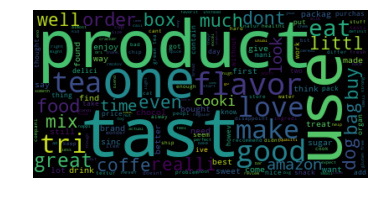

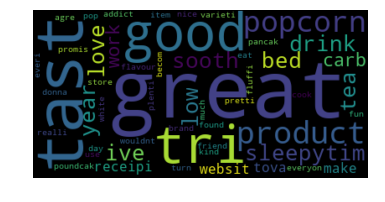

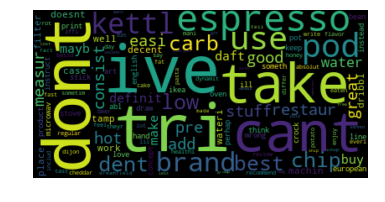

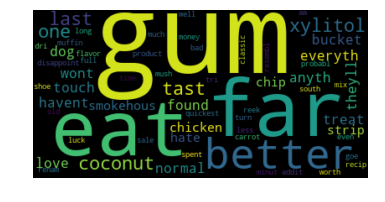

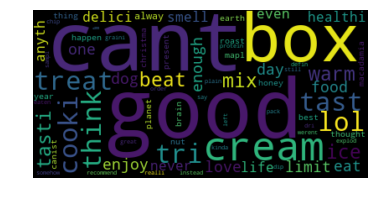

In [35]:
labels = np.array(am_8_Clusters_complete_linkage.labels_)

for cluster_label in range(0, 8):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue
    
    cluster_reviews = filtered_data.iloc[list(grouped_cluster),:]['CleanedText'].tolist()
    cluster_reviews = " ".join(cluster_reviews)
    wc = WordCloud().generate(cluster_reviews)
    plt.figure(cluster_label)
    print(f'------------{cluster_label}----------------')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

1. Not able to infer what is the majority of the reviews about. 
2. Most of the reviwed for all day food items like pancake, popcorn
3. Most of the reviews about hot beverages
4. Most of the reviews are about gum
5. Most of the reviews are about healthy items for life improvement

## DBSCAN

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import random

In [17]:
random_5_indices = random.sample(range(1000,4000),5)

random_5_values = []
for i in random_5_indices:
    random_5_values.append(avg_X_tr[i])

type(random_5_values[0][0])

random_5_values_in_nd_array = np.empty((5,50), np.float64)

random_5_values_in_nd_array[0] = random_5_values[0]
random_5_values_in_nd_array[1] = random_5_values[1]
random_5_values_in_nd_array[2] = random_5_values[2]
random_5_values_in_nd_array[3] = random_5_values[3]
random_5_values_in_nd_array[4] = random_5_values[4]

distances = pairwise_distances(random_5_values_in_nd_array)

distances

array([[ 0.        ,  7.26844497,  9.47945172, 12.39325006,  9.60166434],
       [ 7.26844497,  0.        ,  4.46488678,  9.1641165 ,  9.67540678],
       [ 9.47945172,  4.46488678,  0.        , 12.35919309, 12.22581197],
       [12.39325006,  9.1641165 , 12.35919309,  0.        ,  8.02711571],
       [ 9.60166434,  9.67540678, 12.22581197,  8.02711571,  0.        ]])

In [20]:
dbScan_model = DBSCAN(eps=3, min_samples=5, n_jobs = -1).fit(avg_X_tr)
set(dbScan_model.labels_)

{-1, 0, 1, 2, 3, 4}

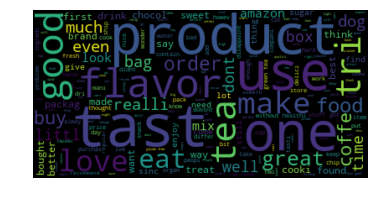

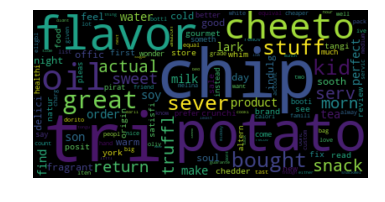

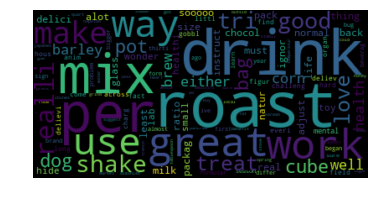

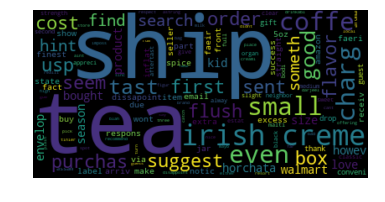

In [23]:
labels = np.array(dbScan_model.labels_)

number_of_clusters = len(set(labels))

for cluster_label in range(0, number_of_clusters):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 3):
        continue

    cluster_reviews = filtered_data.iloc[list(grouped_cluster),:]['CleanedText'].tolist()
    cluster_reviews = " ".join(cluster_reviews)
    wc = WordCloud().generate(cluster_reviews)
    plt.figure(cluster_label)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

<li>first cluster belongs to -1 and we are not able to interpret the theme</li>
<li>Second cluster is about chips and cheeto mostly</li>
<li>Thrid cluster is about beverages and drinks</li>
<li>Fourth cluster is about Tea and good reviews about shipping</li>

# Conclusion

1. K means and Aglomerative do not require any understanding of the data and the algorithm just runs and gives us the clusters
2. DBSCAN demands that we understand the data and choose the eps and min_samples. If we choose them randomly the numbers of clusters is either 0 or [-1, 0]